In [56]:
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from nim_env import NimEnv, OptimalPlayer
import helpers

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import WarningFunctions as wf

env = NimEnv(seed = 3)


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#parameters
GAMMA = 0.99
buffer_size = 10000
BATCH_SIZE = 64
TARGET_UPDATE = 500

#Epsilon greedy : 
EPS_GREEDY = 0.2 #random.random()
print("epsilon greedy : ", EPS_GREEDY)

#-------------------------------- helpers DQN ----------------------------
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
#next state here consists of the next state the DQN player can plays; i.e. not the next state that the game has, but the one after. 

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        random.seed()
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def to_input(heaps):
    #change the format of the heaps so that it can be used as an input for the neural network. 
    init_state = torch.zeros(9, device = device)
    for i in range(3):
        state = bin(heaps[i])[2:]
        j = 0 
        while j < len(state):
            init_state[i*3 + 2 - j] = np.int16(state[len(state) - 1 - j])
            j += 1
    return init_state.clone().detach()

            
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(9, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 21)

    def forward(self, x):
        x = (x.to(device))
        x = x.view(-1, 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class DQN_Player(OptimalPlayer):
    def __init__(self, player, policy_net, target_net, memory, EPS_GREEDY = 0.2, GAMMA = 0.99, buffer_size = 10000, BATCH_SIZE = 64, TARGET_UPDATE = 500, WITHOUT_RB = False):
        super(DQN_Player, self).__init__(player = player)
        self.policy_net = policy_net
        self.target_net = target_net
        self.memory = memory
        self.player = player
        self.EPS_GREEDY = EPS_GREEDY
        self.GAMMA = GAMMA
        self.buffer_size = buffer_size
        self.BATCH_SIZE = BATCH_SIZE
        self.TARGET_UPDATE = TARGET_UPDATE
        self.count = 0 #to count when to update target_net.

        self.optimizer = optim.Adam(policy_net.parameters(), lr = 5*1e-4)
        self.criterion = nn.HuberLoss()
        self.WITHOUT_RB = WITHOUT_RB
        if self.WITHOUT_RB == True : 
            #Q.12 : if the replay buffer is not used, the memory contains only the last update.
            self.BATCH_SIZE = 1
            self.memory = ReplayMemory(1)

        
    def QL_Move(self, heaps):
        state = to_input(heaps)
        global steps_done
        random.seed()
        sample = random.random()
        if sample < self.EPS_GREEDY: 
            with torch.no_grad():
                # t.max(1) will return largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                q = policy_net(state) #size 21
                #print("if eps < sample : policy predicted : ", q)
                argmax = torch.argmax(q)
                result = torch.tensor([argmax.div(7, rounding_mode="floor")+1, torch.remainder(argmax, 7)+1], device = device)
                #print("select action :", result)
                return result
        else:
            random.seed()
            result = torch.tensor([random.randrange(1,4), random.randrange(1,8)], device=device, dtype=torch.long)
            #print("if sample > eps : ", result)
            return result
           
    def act(self, heaps, **kwargs):
        return self.QL_Move(heaps)

    def optimize(self):
        if self.WITHOUT_RB == True:
            batch = self.memory
            if batch.next_state == None :
                next_state_values = torch.zeros(1)
            else :
                next_state_values = self.target_net(batch.next_state).max(1)[0].detach()
            state_batch = batch.state
            action_batch = batch.action
            reward_batch = batch.reward
            state_action_values = self.policy_net(state_batch)
            state_action_values = state_action_values.gather(1, (action_batch[0]-1+(action_batch[1]-1)*3).view(self.BATCH_SIZE, 1))

        else : 
            if len(self.memory) < self.BATCH_SIZE:
                return
            transitions = self.memory.sample(self.BATCH_SIZE)
            # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
            # detailed explanation). This converts batch-array of Transitions
            # to Transition of batch-arrays.
            batch = Transition(*zip(*transitions))    

            # Compute a mask of non-final states and concatenate the batch elements
            # (a final state would've been the one after which simulation ended)
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                                batch.next_state)), device=device, dtype=torch.bool)
            #print("non final mask : ", non_final_mask)
            #print("non final next state : ", [s for s in batch.next_state if s is not None])
            if [s for s in batch.next_state if s is not None] : #is false if the list is empty
                non_final_next_states = torch.cat([s for s in batch.next_state
                                                        if s is not None])
            else : 
                non_final_next_states = torch.empty(1) 
                                  
            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)
            #print("state batch :", state_batch.shape)
            #print("reward batch ", reward_batch)
            # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
            # columns of actions taken. These are the actions which would've been taken
            # for each batch state according to policy_net
            state_action_values = self.policy_net(state_batch) #64 x 21
            #print("state action values : ", state_action_values) 
            #print("action ", action_batch)
            #print("action batch : ", (action_batch[::2]-1+(action_batch[1::2]-1)*3))

            state_action_values = state_action_values.gather(1, (action_batch[::2]-1+(action_batch[1::2]-1)*3).view(self.BATCH_SIZE, 1)) #64 x 1
            #print("state action values after: ", state_action_values.squeeze(1))
            # Compute V(s_{t+1}) for all next states.
            # Expected values of actions for non_final_next_states are computed based
            # on the "older" target_net; selecting their best reward with max(1)[0].
            # This is merged based on the mask, such that we'll have either the expected
            # state value or 0 in case the state was final.
            next_state_values = torch.zeros(self.BATCH_SIZE, device=device)
            if len(non_final_next_states) > 1:
                #print("target net : ")
                #print(target_net(non_final_next_states).shape)
                #print(target_net(non_final_next_states).max(1)[0].shape)
                next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach() # max(1) : take the maximum per batch on the 21 possibilities. [0]: take the max and not the argmax
                #print("Next state values : ", next_state_values)
                
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch  #64
        #print("expected state action values : ", expected_state_action_values) #64 x 1

        # Compute Huber loss
        loss = self.criterion(state_action_values, expected_state_action_values.unsqueeze(1).detach())
        # Optimize the model
        self.optimizer.zero_grad()
        #print("before : ", policy_net.named_parameters().data)
        loss.backward()
        #print("after : ", policy_net.named_parameters().data)
        
        #for param in policy_net.parameters():
            #param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        return loss.item()
    
    def update_target(self):
        #count the number of games played by the DQN player and update the target_net after TARGET_UPDATE games.
        self.count += 1
        if self.count == self.TARGET_UPDATE:
            self.target_net.load_state_dict(self.policy_net.state_dict())
            self.count = 0

    def memory_push(self, state, action, next_state, reward):
        if self.WITHOUT_RB == False :
            self.memory.push(state, action, next_state, reward)
        else :
            self.memory = Transition(state, action, next_state, reward)


def DQN_one_game(playerDQN, playerOpt, env, update = True):
    heaps, _, _ = env.observe()
    loss = None
    #env.render()
    i = 0
    while not env.end:
        #print("to input ", to_input(heaps))
        if env.current_player == playerOpt.player:
            move = playerOpt.act(heaps)
            heaps, end, winner = env.step(move)
            #print("OPT player plays:")
            if i > 0 and update == True:
                # Store the transition in memory
                reward = torch.tensor([env.reward(player = playerDQN.player)], device=device)
                #print("in memory push : ", state_DQN, move_DQN, to_input(heaps), reward)
                playerDQN.memory_push(state_DQN, move_DQN, next_state = to_input(heaps), reward = reward)
                loss = playerDQN.optimize()
        else: 
            move_DQN = playerDQN.act(heaps)
            #print("move : ", move)
            state_DQN = to_input(heaps)
            is_available = env.check_valid(move_DQN)
            if not is_available: 
                #print("not available")
                #i.e. if the action is not valid, we give the agent a negative reward
                #print("is not available : ", is_available)
                #env.render()
                #print("action : ", action)
                reward = torch.tensor([-1], device=device)
                next_state = None
                #print("in memory push : ", state_DQN, move_DQN, next_state, reward)
                playerDQN.memory_push(state_DQN, move_DQN, next_state, reward)
                loss = playerDQN.optimize()
                break
            else : #if the action is valid, we make a step
                #print("is available : ", is_available)
                heaps, done, _ = env.step(move_DQN)
                #print("DQN player plays:")
                if done:
                    next_state = None
                    reward = torch.tensor([1], device=device)
                    #print("in memory push : ", state_DQN, move_DQN, next_state, reward)
                    playerDQN.memory_push(state_DQN, move_DQN, next_state, reward)
              
        i += 1
    #env.render()
    playerDQN.update_target()
    return env.reward(playerDQN.player), loss


def Q1_DQN(policy_net, target_net, memory, nb_games = 20000, eps = 0.2, eps_opt = 0.5, step = 250, seed = None, question = 'q3-11', WITHOUT_RB = False):
    Rewards = []
    Losses = []
    Steps = []
    total_reward = 0.0
    total_loss = 0.0
    env = NimEnv(seed = seed)
    playerOpt = OptimalPlayer(epsilon = eps_opt, player = 0)
    playerDQN = DQN_Player(player = 1, policy_net = policy_net, target_net= target_net, memory=memory, EPS_GREEDY = eps, WITHOUT_RB = WITHOUT_RB) 
    for i in range(nb_games):
        if i % step ==0:
           print('New game : ', i)
        # switch turns at every game
        if i % 2 == 0:
            playerOpt.player = 0
            playerDQN.player = 1
        else:
            playerOpt.player = 1
            playerDQN.player = 0
        
        new_reward, new_loss = DQN_one_game(playerDQN, playerOpt, env)
        total_reward += new_reward
        if new_loss != None:
            total_loss += new_loss
        if i % step == step - 1:
            Rewards.append(total_reward / step)
            Losses.append(total_loss / step)
            Steps.append(i)
            total_reward = 0.0
            total_loss = 0.0

        env.reset()
        #print(playerQL.qvals['746'])
    plt.figure(figsize = (7, 7))
    plt.plot(Steps, Rewards)
    plt.title('Evolution of average reward every 250 games')
    plt.xlabel('Number of games played')
    plt.ylabel('Average reward for QL-player')
    plt.savefig('./Data/' + question + '_rewards.png')
    plt.show()

    plt.figure(figsize = (7, 7))
    plt.plot(Steps, Losses)
    plt.title('Evolution of average loss every 250 games')
    plt.xlabel('Number of games played')
    plt.ylabel('Average reward for QL-player')
    plt.savefig('./Data/' + question + '_losses.png')
    plt.show()


epsilon greedy :  0.2


# 3.2


In [55]:
eps_opt = 0.5
eps = 0.2
seed = 3
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
memory = ReplayMemory(buffer_size)
env = NimEnv(seed = seed)
env.step([1,1])
env.step([2,5])
env.step([3,5])
playerOpt = OptimalPlayer(epsilon = eps_opt, player = 1)
playerDQN = DQN_Player(player = 0, policy_net = policy_net, target_net= target_net, memory=memory, EPS_GREEDY = eps)
DQN_one_game(playerDQN, playerOpt, env) 

(0, None)

Question 11

In [57]:
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
memory = ReplayMemory(buffer_size)

In [58]:
Q1_DQN(policy_net, target_net, memory, eps_opt = 1, nb_games=20000, question = 'q3-11')

New game :  0
New game :  250
New game :  500
New game :  750
New game :  1000
New game :  1250
New game :  1500
New game :  1750
New game :  2000
New game :  2250
New game :  2500
New game :  2750
New game :  3000
New game :  3250
New game :  3500
New game :  3750
New game :  4000
New game :  4250
New game :  4500
New game :  4750
New game :  5000
New game :  5250
New game :  5500
New game :  5750
New game :  6000
New game :  6250
New game :  6500
New game :  6750
New game :  7000
New game :  7250
New game :  7500
New game :  7750
New game :  8000
New game :  8250
New game :  8500
New game :  8750
New game :  9000
New game :  9250
New game :  9500
New game :  9750
New game :  10000
New game :  10250
New game :  10500
New game :  10750
New game :  11000
New game :  11250
New game :  11500
New game :  11750


Question 12


New game :  0
New game :  250
New game :  500
New game :  750
New game :  1000
New game :  1250
New game :  1500
New game :  1750
New game :  2000
New game :  2250
New game :  2500
New game :  2750
New game :  3000
New game :  3250
New game :  3500
New game :  3750
New game :  4000
New game :  4250
New game :  4500
New game :  4750
New game :  5000
New game :  5250
New game :  5500
New game :  5750
New game :  6000
New game :  6250
New game :  6500
New game :  6750
New game :  7000
New game :  7250
New game :  7500
New game :  7750
New game :  8000
New game :  8250
New game :  8500
New game :  8750
New game :  9000
New game :  9250
New game :  9500
New game :  9750


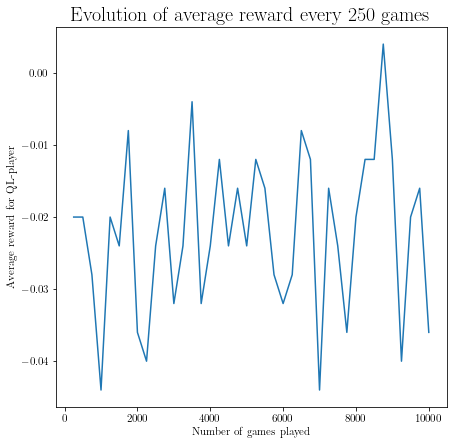

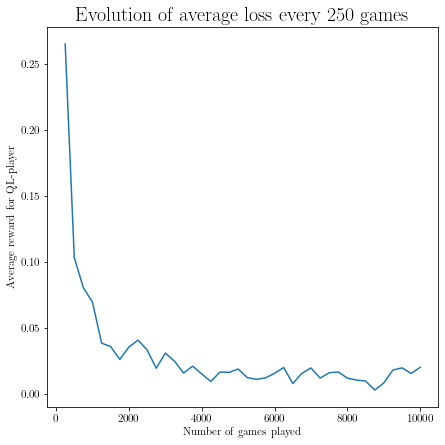

In [8]:
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
memory = []
Q1_DQN(policy_net, target_net, memory, eps_opt = 1, nb_games=10000, question='q3-12', WITHOUT_RB = True)

Question 13

In [24]:
def DQN_Q14(N_star, policy_net, target_net, memory, nb_games = 20000, eps_min = 0.1, eps_max = 0.8, alpha = 0.1, gamma = 0.99, 
       step = 250, seed = None, question = 'q3-14', nb_samples = 5, save = True):
    """
    Implements the solution to the 14th question
    - inputs: 
        - N_star: a list containing the values of n*, dtype: list
        - nb_games: the number of games to play. Default: 20000, dtype: int
        - eps_min: the minimal value for the exploration level of the QL-player. Default: 0.1, dtype: float
        - eps_max: the maximal value for the exploration level of the QL-player. Default: 0.8, dtype: float
        - alpha: learning rate of the QL-player. Default: 0.1, dtype: float
        - gamma: discount factor of the QL-player. Default: 0.99, dtype: float
        - step: number of games to play before calculating the average reward. Default: 250, dtype: int
        - seed: the user can set a given seed for reproducibility. Default: None
        - question: string used to differentiate between the plots for each question. 
            Only used if 'save' is True. Default: 'q3-14', dtype: str
        - nb_samples: if this number is higher than 1, the 'nb_games' are played several times and then averaged in order to take into account the schocasticity of te problem. Default: 5, dtype: int
        - save: if set to False, the plots are only displayed but not saved. Default: True, dtype: bool
    - outputs: 
        - a figure with a plot for each n* representing the average reward every 'step' games for the QL-player. According to the value of the argument 'nb_samples', two different figures can be produced. Figures are saved in a folder Data if the argument 'save' is set to True.
        - returns the final rewards for each n* as a dictionnary
    """
    #wf.Q2_warning(N_star, nb_games, eps_min, eps_max, alpha, gamma, step, question, nb_samples, save)
    
    plt.figure(figsize = (9, 8))
    legend = []
    Final_rewards = {}
    for j, n_star in enumerate(N_star):
        Rewards = np.zeros(int(nb_games / step))
        Steps = np.zeros(int(nb_games / step))
        for s in range(nb_samples):
            env = NimEnv(seed = seed)
            eps = max(eps_min, eps_max * (1 - 1 / n_star))
            playerOpt = OptimalPlayer(epsilon = 0.5, player = 0)
            playerDQN = DQN_Player(player = 1, policy_net = policy_net, target_net= target_net, memory=memory, EPS_GREEDY = eps) 
            total_reward = 0.0
            for i in range(nb_games):
                # switch turns at every game
                if i % 2 == 0:
                    playerOpt.player = 0
                    playerDQN.player = 1
                else:
                    playerOpt.player = 1
                    playerDQN.player = 0
        
                new_reward, _ = DQN_one_game(playerDQN, playerOpt, env, update = True)
                total_reward += new_reward
                if i % step == step - 1:
                    Rewards[i // step] += total_reward / step
                    total_reward = 0.
                    Steps[i // step] = i
                env.reset(seed = seed)
                playerDQN.EPS_GREEDY = max(eps_min, eps_max * (1 - (i + 2) / n_star)) # change eps for the next game (current game is (i+1))
        Rewards = Rewards / nb_samples
        plt.plot(Steps, Rewards)
        Final_rewards['{}'.format(n_star)] = Rewards[-1]
        legend.append(r"$n_* = {}$".format(n_star))
    plt.legend(legend)
    plt.title('Evolution of average reward with decrease of exploration level')
    plt.xlabel('Number of games played')
    plt.ylabel('Average reward for QL-player')
    if save:
        if nb_samples > 1:
            plt.savefig('./Data/' + question + '_' + str(nb_samples) + '_samples.png')
        else:
            plt.savefig('./Data/' + question + '.png')
    return Final_rewards

FAIRE RUNNER EN BAS ET FAIRE Q.14

In [25]:
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
memory = ReplayMemory(buffer_size)
N_star = [2, 3]
DQN_Q14(N_star, policy_net, target_net, memory)